In [1]:
ROOT_DIR = r"C:\Users\wyattluke.lowery\Documents\GitHub\laplib"

BUNNY_PLY1 = ROOT_DIR + r"\StanfardBunny\src\Stanford Bunny\reconstruction\bun_zipper.ply"
BUNNY_PLY2 = ROOT_DIR + r"\StanfardBunny\src\Stanford Bunny\reconstruction\bun_zipper_res2.ply"
BUNNY_PLY3 = ROOT_DIR + r"\StanfardBunny\src\Stanford Bunny\reconstruction\bun_zipper_res3.ply"
BUNNY_PLY4 = ROOT_DIR + r"\StanfardBunny\src\Stanford Bunny\reconstruction\bun_zipper_res4.ply"

HORSE = ROOT_DIR + r"\Horse\horse.ply"

BRAIN = ROOT_DIR + r"\Brain\lh.pial.ply"


from esapp.utils import Mesh 

import numpy as np
import scipy.sparse as sp
import os
import scipy.io as sio

Helper Functions for Generating Data

In [2]:
def fomrat_edges(M):
    
    B: sp.csc_matrix = M.get_incidence_matrix()

    B[B<0] = 0

    B.eliminate_zeros()
    B = B.tocoo()

    edges = np.stack([B.row, B.col, B.data], axis=1)

    return edges

def write_edges_txt(filepath, edge_matrix, feature_names=None):
    # This function generates the edges.txt file

    data = np.array(edge_matrix)
    
    # Validate dimensions
    if data.ndim != 2 or data.shape[1] < 2:
        raise ValueError("Input matrix must be M x (2+K) with at least source and target columns.")

    num_features = data.shape[1] - 2

    # Handle feature names
    if feature_names is None:
        feature_names = [f"feature_{i+1}" for i in range(num_features)]
        
    if len(feature_names) != num_features:
        raise ValueError(f"Provided {len(feature_names)} names for {num_features} feature columns.")

    # Construct header
    header = ["source", "target"] + feature_names

    with open(filepath, 'w') as f:
        # Write Header
        f.write(" ".join(header) + "\n")
        
        # Write Rows
        for row in data:
            # Enforce integer formatting for source and target indices
            src, tgt = int(row[0]), int(row[1])
            
            # Format features (preserves float formatting from numpy)
            features = row[2:]
            
            if len(features) > 0:
                features_str = " ".join(map(str, features))
                f.write(f"{src} {tgt} {features_str}\n")
            else:
                f.write(f"{src} {tgt}\n")

def write_signals_txt(filepath, signal_matrix, signal_names=None):
    # This generates the signals.txt file
    data = np.array(signal_matrix)
    
    # Ensure 2D array (N x D). If 1D input, treat as N x 1.
    if data.ndim == 1:
        data = data.reshape(-1, 1)
    
    if data.ndim != 2:
        raise ValueError("Input data must be a 2D matrix (N x D).")

    num_cols = data.shape[1]

    # Validate signal names if provided
    if signal_names is not None:
        if len(signal_names) != num_cols:
            raise ValueError(f"Provided {len(signal_names)} names for {num_cols} columns.")

    with open(filepath, 'w') as f:
        # Write Header if names are provided
        if signal_names:
            f.write(" ".join(signal_names) + "\n")
        
        # Write Rows
        for row in data:
            # Join row elements with spaces
            # map(str, row) handles both float and int types correctly
            f.write(" ".join(map(str, row)) + "\n")

Generate the Laplacian, `edges.txt` and `signals.txt`.

In [3]:
M = Mesh.from_ply(BRAIN)

write_edges_txt(
    "edges.txt",
    fomrat_edges(M),
    ['weight']
)


write_signals_txt(
    "signals.txt",
    M.get_xyz(),
    ['x', 'y', 'z']
)

sio.savemat(f"lap.mat", {
    "A": M.to_laplacian()
})

### Data Inspection

In [4]:

def inspect_ply(file_path):
    M = Mesh.from_ply(file_path )
    B = M.get_incidence_matrix()

    num_vert = len(M.vertices)
    num_edge = B.shape[1]

    print(f"Verticies: {num_vert}")
    print(f"Edges: {num_edge}")

In [5]:
inspect_ply(BRAIN)

Verticies: 144490
Edges: 433464


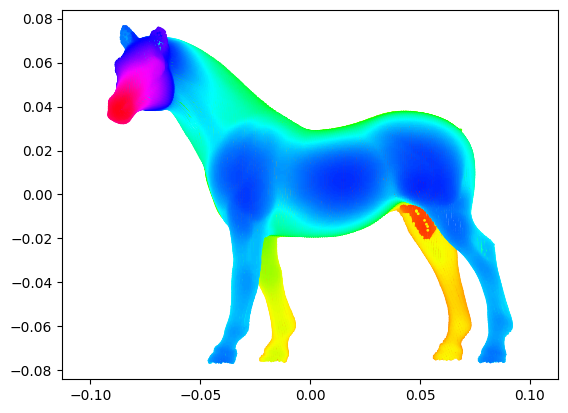

In [31]:
xyz = M.get_xyz()

from matplotlib.colors import Normalize
import matplotlib.pyplot as plt 

# Rotate the horse for better viewing
# about each axis

def rotation_matrix_x(deg):
    angle = np.radians(deg)
    return np.array([
        [1, 0, 0],
        [0, np.cos(angle), -np.sin(angle)],
        [0, np.sin(angle),  np.cos(angle)]
    ])

def rotation_matrix_y(deg):
    angle = np.radians(deg)
    return np.array([
        [ np.cos(angle), 0, np.sin(angle)],
        [ 0,             1, 0           ],
        [-np.sin(angle), 0, np.cos(angle)]
    ])
def rotation_matrix_z(deg):
    angle = np.radians(deg)
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle),  np.cos(angle), 0],
        [0,              0,             1]
    ])

def rotate_xyz(xyz, deg_x=0, deg_y=0, deg_z=0):
    R_x = rotation_matrix_x(deg_x)
    R_y = rotation_matrix_y(deg_y)
    R_z = rotation_matrix_z(deg_z)

    R = R_z @ R_y @ R_x

    return xyz @ R.T

rotated_xyz = rotate_xyz(xyz, 0, 90, 90)

# Sort by z-value so points with larger z are drawn on top
order = np.argsort(rotated_xyz[:, 2])
rotated_xyz = rotated_xyz[order]

norm = Normalize(vmin=rotated_xyz[:,2].min(), vmax=rotated_xyz[:,2].max())

plt.scatter(rotated_xyz[:,0], rotated_xyz[:,1], c=rotated_xyz[:,2], norm=norm, cmap='hsv', s=1)
plt.axis('equal')
plt.show()